<a href="https://colab.research.google.com/github/samservo09/bioinformatics-bipolar-drug-discovery/blob/main/2-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bioinformatics: Drug discovery on Norepinephrine transporter protein

## Install necessary packages/libraries

**RDKit** - collection of open-source cheminformatics and machine-learning software written in C++ and Python.

In [1]:
# install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2024-10-13 06:44:53--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’

Miniconda3-py37_4.8 100%[===================>]  81.12M   167MB/s    in 0.5s    

2024-10-13 06:44:54 (167 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
 

## Load bioactivity data

In [2]:
import pandas as pd

In [3]:
! wget https://raw.githubusercontent.com/samservo09/bioinformatics-bipolar-drug-discovery/refs/heads/main/data/CaMKK2/Norepinephrine/Norepinephrine_preprocessed_data.csv

--2024-10-13 06:46:11--  https://raw.githubusercontent.com/samservo09/bioinformatics-bipolar-drug-discovery/refs/heads/main/data/CaMKK2/Norepinephrine/Norepinephrine_preprocessed_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180824 (177K) [text/plain]
Saving to: ‘Norepinephrine_preprocessed_data.csv.2’

Norepinephrine_prep 100%[===================>] 176.59K  --.-KB/s    in 0.004s  

2024-10-13 06:46:11 (42.8 MB/s) - ‘Norepinephrine_preprocessed_data.csv.2’ saved [180824/180824]



In [4]:
df = pd.read_csv('Norepinephrine_preprocessed_data.csv')

In [5]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL132683,COC(=O)C1C(c2ccc(O)c(O)c2)CC2CCC1N2C,173.00,active
1,CHEMBL544370,Cl.OC1(c2ccc3c(c2)OCO3)c2ccccc2C2=NCCCN21,0.62,active
2,CHEMBL417049,CN(CCOC(c1ccccc1)c1ccccc1)C1CCN(CCCc2ccccc2)CC1,200.00,active
3,CHEMBL26320,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1,165.00,active
4,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,233.00,active
...,...,...,...,...
2580,CHEMBL5219762,[2H]C([2H])([2H])C(N[C@@]([2H])(C)C(=O)c1cccc(...,1000.00,active
2581,CHEMBL4745144,CNCC[C@H](Oc1cccc(N2CCN(C)c3nc(N)ncc3C2=O)c1)c...,7.00,active
2582,CHEMBL4635134,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O,100000.00,inactive
2583,CHEMBL4639128,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC[C@H]4CCNC4)cc...,19952.62,inactive


## Calculate descriptors

**Lipinski descriptors** - "Rule of Five" <br>
- set of rules to evaluate the druglikeness of a compound <br>
- druglikeness is based on ADME (Absorption, Distribution, Metabolism, and Excretion) aka "pharmacokinetic profile" <br>

**Rule of Five** <br>
*   Molecular weight < 500 Dalton
*   Octanol-water partition coefficient (LogP) < 5
*   Hydrogen bond donors < 5
*   Hydrogen bond acceptors < 10



*Note: compounds that violate more than 1 of these rules are likely to have poor absorpiton making them less suitable for oral administration as drugs.*

Further explanation for each rule: <br>
*   **Molecules with higher molecular weights** tend to have **difficulty passing through** cell membranes, which is crucial for absorption and distribution in the body <br>
*   **LogP is a way to measure if a molecule prefers to dissolve in fat (octanol) or in water.** If it likes fat a lot (high LogP), it can be hard for it to mix with water, making it difficult for our body to absorb it. <br>
*   When molecules have groups like OH or NH, they stick to water really well. This **strong sticking can make it harder for those molecules to get through the protective barriers** (membranes) of cells.<br>
*   Hydrogen bond acceptors, like oxygen and nitrogen, can attract water. This can make it **difficult for certain molecules to pass through the cell's protective barrier** (membrane).

In [6]:
! pip install -q rdkit

In [7]:
# import libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [8]:
df.canonical_smiles.head(4)

,canonical_smiles
0,COC(=O)C1C(c2ccc(O)c(O)c2)CC2CCC1N2C
1,Cl.OC1(c2ccc3c(c2)OCO3)c2ccccc2C2=NCCCN21
2,CN(CCOC(c1ccccc1)c1ccccc1)C1CCN(CCCc2ccccc2)CC1
3,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1


In [9]:
# check if canonical_smiles has NaN values
df.canonical_smiles.isna().sum()

2

In [10]:
# drop the columns with NaN canonical_smiles values
df = df.dropna(subset=['canonical_smiles'])

In [11]:
# calculate descriptors
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [12]:
# turn the canonical smiles column into a dataframe
df_lipinski = lipinski(df.canonical_smiles)

In [13]:
# lipinski dataframe
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,291.347000,1.83710,2.0,5.0
1,344.798000,2.49640,1.0,5.0
2,442.647000,5.82160,0.0,3.0
3,414.593000,5.04300,0.0,3.0
4,303.358000,1.86770,0.0,5.0
...,...,...,...,...
2578,249.807018,3.29930,1.0,2.0
2579,438.557000,2.94650,2.0,8.0
2580,325.368000,1.14840,2.0,4.0
2581,511.626000,5.60034,1.0,8.0


In [14]:
# check for null values
df_lipinski.isna().sum()

,0
MW,0
LogP,0
NumHDonors,0
NumHAcceptors,0


In [15]:
# original dataframe
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL132683,COC(=O)C1C(c2ccc(O)c(O)c2)CC2CCC1N2C,173.00,active
1,CHEMBL544370,Cl.OC1(c2ccc3c(c2)OCO3)c2ccccc2C2=NCCCN21,0.62,active
2,CHEMBL417049,CN(CCOC(c1ccccc1)c1ccccc1)C1CCN(CCCc2ccccc2)CC1,200.00,active
3,CHEMBL26320,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1,165.00,active
4,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,233.00,active
...,...,...,...,...
2580,CHEMBL5219762,[2H]C([2H])([2H])C(N[C@@]([2H])(C)C(=O)c1cccc(...,1000.00,active
2581,CHEMBL4745144,CNCC[C@H](Oc1cccc(N2CCN(C)c3nc(N)ncc3C2=O)c1)c...,7.00,active
2582,CHEMBL4635134,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O,100000.00,inactive
2583,CHEMBL4639128,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC[C@H]4CCNC4)cc...,19952.62,inactive


In [16]:
# check if there are null or NaN values
df.isna().sum()

,0
molecule_chembl_id,0
canonical_smiles,0
standard_value,0
bioactivity_class,0


In [18]:
df.shape

(2583, 4)

In [19]:
print(df.dtypes)  # Prints the data type of each column
print(df_lipinski.dtypes)

molecule_chembl_id     object
canonical_smiles       object
standard_value        float64
bioactivity_class      object
dtype: object
MW               float64
LogP             float64
NumHDonors       float64
NumHAcceptors    float64
dtype: object


In [75]:
# Step 1: Remove NaN values from both DataFrames before concatenation
df = df.dropna(subset=['standard_value', 'molecule_chembl_id', 'canonical_smiles', 'bioactivity_class']).reset_index(drop=True)
df_lipinski = df_lipinski.dropna(subset=['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']).reset_index(drop=True)

# Step 2: Concatenate the cleaned DataFrames
df_combined = pd.concat([df, df_lipinski], axis=1)

# Step 3: Remove any rows with NaN values in the combined DataFrame (if needed)
df_combined = df_combined.dropna().reset_index(drop=True)

In [77]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL132683,COC(=O)C1C(c2ccc(O)c(O)c2)CC2CCC1N2C,173.00,active
1,CHEMBL544370,Cl.OC1(c2ccc3c(c2)OCO3)c2ccccc2C2=NCCCN21,0.62,active
2,CHEMBL417049,CN(CCOC(c1ccccc1)c1ccccc1)C1CCN(CCCc2ccccc2)CC1,200.00,active
3,CHEMBL26320,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1,165.00,active
4,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,233.00,active
...,...,...,...,...
2578,CHEMBL5219762,[2H]C([2H])([2H])C(N[C@@]([2H])(C)C(=O)c1cccc(...,1000.00,active
2579,CHEMBL4745144,CNCC[C@H](Oc1cccc(N2CCN(C)c3nc(N)ncc3C2=O)c1)c...,7.00,active
2580,CHEMBL4635134,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O,100000.00,inactive
2581,CHEMBL4639128,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC[C@H]4CCNC4)cc...,19952.62,inactive


In [78]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL132683,COC(=O)C1C(c2ccc(O)c(O)c2)CC2CCC1N2C,173.00,active,291.347000,1.83710,2.0,5.0
1,CHEMBL544370,Cl.OC1(c2ccc3c(c2)OCO3)c2ccccc2C2=NCCCN21,0.62,active,344.798000,2.49640,1.0,5.0
2,CHEMBL417049,CN(CCOC(c1ccccc1)c1ccccc1)C1CCN(CCCc2ccccc2)CC1,200.00,active,442.647000,5.82160,0.0,3.0
3,CHEMBL26320,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1,165.00,active,414.593000,5.04300,0.0,3.0
4,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,233.00,active,303.358000,1.86770,0.0,5.0
...,...,...,...,...,...,...,...,...
2578,CHEMBL5219762,[2H]C([2H])([2H])C(N[C@@]([2H])(C)C(=O)c1cccc(...,1000.00,active,249.807018,3.29930,1.0,2.0
2579,CHEMBL4745144,CNCC[C@H](Oc1cccc(N2CCN(C)c3nc(N)ncc3C2=O)c1)c...,7.00,active,438.557000,2.94650,2.0,8.0
2580,CHEMBL4635134,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O,100000.00,inactive,325.368000,1.14840,2.0,4.0
2581,CHEMBL4639128,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC[C@H]4CCNC4)cc...,19952.62,inactive,511.626000,5.60034,1.0,8.0


## Convert IC50 to pIC50

To allow **IC50** data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially **-log10(IC50)**.

In [79]:
! pip install -q seaborn
! pip install -q matplotlib

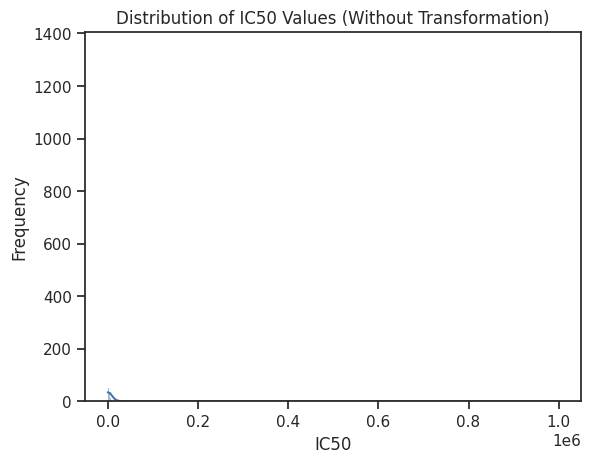

In [80]:
# distribution of ic50 values without transformation
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_combined['standard_value'], kde=True)
plt.xlabel('IC50')
plt.ylabel('Frequency')
plt.title('Distribution of IC50 Values (Without Transformation)')
plt.show()

In [81]:
# accepts dataframe as input to apply log transformation (negative logarithmic scale)
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)

    return x

*Note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.*

In [82]:
df_combined.standard_value.describe()

,standard_value
count,2583.000000
mean,6148.422740
std,37621.423679
min,0.000000
25%,26.000000
50%,240.000000
75%,2000.000000
max,1000000.000000


In [83]:
# need to cap the max value to 100 million to have positive values
-np.log10( (10**-9)* 100000000 )

1.0

In [84]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [91]:
# normalize the standard value column with max value of 100 million
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    # Changed code: Use axis=1 instead of 1
    x = input.drop('standard_value', axis=1)

    return x

In [92]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL132683,COC(=O)C1C(c2ccc(O)c(O)c2)CC2CCC1N2C,active,291.347000,1.83710,2.0,5.0,173.00
1,CHEMBL544370,Cl.OC1(c2ccc3c(c2)OCO3)c2ccccc2C2=NCCCN21,active,344.798000,2.49640,1.0,5.0,0.62
2,CHEMBL417049,CN(CCOC(c1ccccc1)c1ccccc1)C1CCN(CCCc2ccccc2)CC1,active,442.647000,5.82160,0.0,3.0,200.00
3,CHEMBL26320,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1,active,414.593000,5.04300,0.0,3.0,165.00
4,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,active,303.358000,1.86770,0.0,5.0,233.00
...,...,...,...,...,...,...,...,...
2578,CHEMBL5219762,[2H]C([2H])([2H])C(N[C@@]([2H])(C)C(=O)c1cccc(...,active,249.807018,3.29930,1.0,2.0,1000.00
2579,CHEMBL4745144,CNCC[C@H](Oc1cccc(N2CCN(C)c3nc(N)ncc3C2=O)c1)c...,active,438.557000,2.94650,2.0,8.0,7.00
2580,CHEMBL4635134,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O,inactive,325.368000,1.14840,2.0,4.0,100000.00
2581,CHEMBL4639128,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC[C@H]4CCNC4)cc...,inactive,511.626000,5.60034,1.0,8.0,19952.62


In [87]:
# summary of capped max value
df_norm.standard_value_norm.describe()

,standard_value_norm
count,2583.000000
mean,6148.422740
std,37621.423679
min,0.000000
25%,26.000000
50%,240.000000
75%,2000.000000
max,1000000.000000


In [107]:
# apply the log transformation to the normalized df
df_final = pIC50(df_norm)
df_final

<ipython-input-81-92251245a4eb>:9: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))


,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL132683,COC(=O)C1C(c2ccc(O)c(O)c2)CC2CCC1N2C,active,291.347000,1.83710,2.0,5.0,6.761954
1,CHEMBL544370,Cl.OC1(c2ccc3c(c2)OCO3)c2ccccc2C2=NCCCN21,active,344.798000,2.49640,1.0,5.0,9.207608
2,CHEMBL417049,CN(CCOC(c1ccccc1)c1ccccc1)C1CCN(CCCc2ccccc2)CC1,active,442.647000,5.82160,0.0,3.0,6.698970
3,CHEMBL26320,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1,active,414.593000,5.04300,0.0,3.0,6.782516
4,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,active,303.358000,1.86770,0.0,5.0,6.632644
...,...,...,...,...,...,...,...,...
2578,CHEMBL5219762,[2H]C([2H])([2H])C(N[C@@]([2H])(C)C(=O)c1cccc(...,active,249.807018,3.29930,1.0,2.0,6.000000
2579,CHEMBL4745144,CNCC[C@H](Oc1cccc(N2CCN(C)c3nc(N)ncc3C2=O)c1)c...,active,438.557000,2.94650,2.0,8.0,8.154902
2580,CHEMBL4635134,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O,inactive,325.368000,1.14840,2.0,4.0,4.000000
2581,CHEMBL4639128,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC[C@H]4CCNC4)cc...,inactive,511.626000,5.60034,1.0,8.0,4.700000


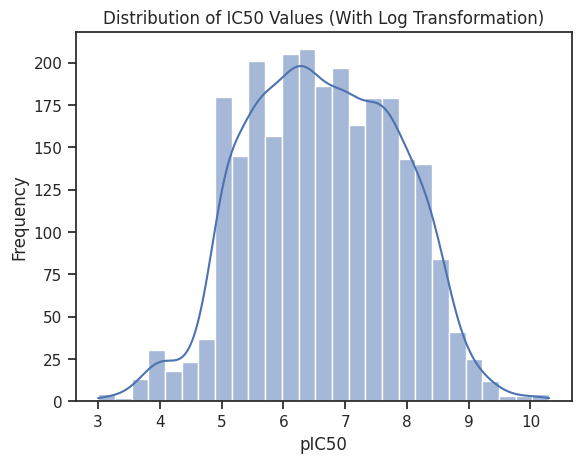

In [108]:
# distribution of ic50 values with transformation
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_final['pIC50'], kde=True)
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.title('Distribution of IC50 Values (With Log Transformation)')
plt.show()

**Explanation:** <br>
*   The range is more compressed. <br>
*   The distribution of pIC50 values is closer to a normal distribution (bell-shaped curve)




In [113]:
# remove rows with inf and null values
df_final = df_final.dropna()

# Remove rows where pIC50 is exactly inf
df_final = df_final[df_final['pIC50'] != np.inf]

# Remove rows where pIC50 is NaN
df_final = df_final[df_final['pIC50'].notnull()]

In [114]:
# summary of final dataframe
df_final.describe()

,MW,LogP,NumHDonors,NumHAcceptors,pIC50
count,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000
mean,331.202085,3.678734,1.019752,3.073974,6.637781
std,84.757705,1.271411,0.998642,1.778828,1.204211
min,135.210000,-12.394900,0.000000,0.000000,3.000000
25%,279.855000,2.884200,1.000000,2.000000,5.698970
50%,313.444000,3.665550,1.000000,3.000000,6.618886
75%,372.415500,4.470425,1.000000,4.000000,7.585027
max,1736.185000,12.390100,21.000000,42.000000,10.301030


## Remove the 'intermediate' bioactivity class

In [115]:
# remove intermediate class from the dataset to focus on the inactive and active classes
df_2class = df_final[df_final['bioactivity_class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL132683,COC(=O)C1C(c2ccc(O)c(O)c2)CC2CCC1N2C,active,291.347000,1.83710,2.0,5.0,6.761954
1,CHEMBL544370,Cl.OC1(c2ccc3c(c2)OCO3)c2ccccc2C2=NCCCN21,active,344.798000,2.49640,1.0,5.0,9.207608
2,CHEMBL417049,CN(CCOC(c1ccccc1)c1ccccc1)C1CCN(CCCc2ccccc2)CC1,active,442.647000,5.82160,0.0,3.0,6.698970
3,CHEMBL26320,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1,active,414.593000,5.04300,0.0,3.0,6.782516
4,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,active,303.358000,1.86770,0.0,5.0,6.632644
...,...,...,...,...,...,...,...,...
2578,CHEMBL5219762,[2H]C([2H])([2H])C(N[C@@]([2H])(C)C(=O)c1cccc(...,active,249.807018,3.29930,1.0,2.0,6.000000
2579,CHEMBL4745144,CNCC[C@H](Oc1cccc(N2CCN(C)c3nc(N)ncc3C2=O)c1)c...,active,438.557000,2.94650,2.0,8.0,8.154902
2580,CHEMBL4635134,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O,inactive,325.368000,1.14840,2.0,4.0,4.000000
2581,CHEMBL4639128,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC[C@H]4CCNC4)cc...,inactive,511.626000,5.60034,1.0,8.0,4.700000


### Download the preprocessed file

In [116]:
# download the df as csv
df_final.to_csv('Norepinephrine_bioactivity_data_3class_pIC50.csv', index=False)
df_2class.to_csv('Norepinephrine_bioactivity_data_2class_pIC50.csv', index=False)

In [117]:
# copy the file to google drive to be accessible within colab
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [118]:
# copy the file to the data folder
! cp Norepinephrine_bioactivity_data_3class_pIC50.csv "/content/gdrive/My Drive/Colab Notebooks/data/"
! cp Norepinephrine_bioactivity_data_2class_pIC50.csv "/content/gdrive/My Drive/Colab Notebooks/data/"

## Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors

Allows us to look at the **chemical space** (like chemical universe). **Chemical compound** (stars), **active molecules** (constellation).

**Constellation plot** - whereby you can perform chemical space analysis wherein the active molecule would correspondingly have larger size in comparison to less active molecule.

### Frequency plot for bioactivity classes

In [119]:
# import library
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

<ipython-input-120-b2855de5c01c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black', palette=colors)


<Figure size 550x1000 with 0 Axes>

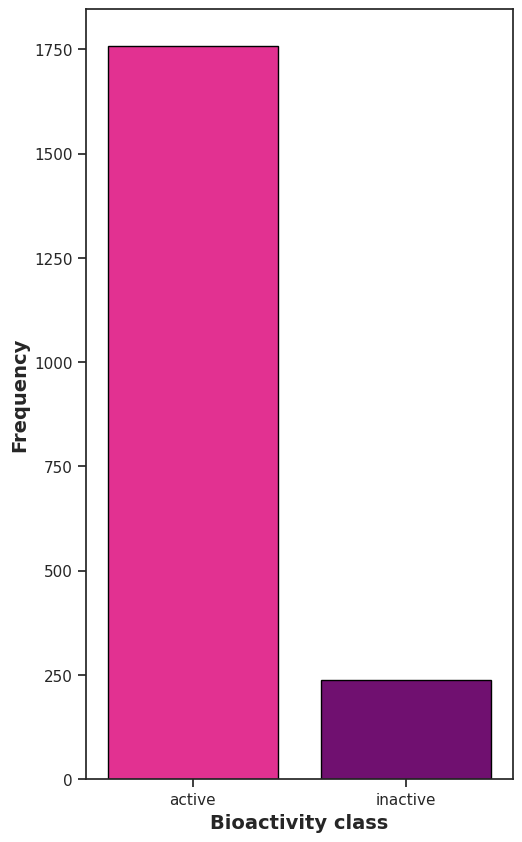

In [120]:
# frequency plot of 2 bioactivity classes
plt.figure(figsize=(5.5, 10))
plt.figure(figsize=(5.5, 10))

colors = ['deeppink', 'purple']
sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black', palette=colors)


plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('Norepinephrine_plot_2_bioactivity_class.pdf')

### Saving of frequency visualization

In [121]:
# create a data folder in the colab notebook folder
! mkdir -p "/content/gdrive/My Drive/Colab Notebooks/visualization/"

In [122]:
# copy the file to the visualization folder
! cp Norepinephrine_plot_2_bioactivity_class.pdf "/content/gdrive/My Drive/Colab Notebooks/visualization/"

In [123]:
# list the files in visualization folder
! ls "/content/gdrive/My Drive/Colab Notebooks/visualization/"

boxplot_ic50.pdf  boxplot_NumHAcceptors.pdf		       plot_2_bioactivity_class.pdf
boxplot_LogP.pdf  boxplot_NumHDonors.pdf		       plot_ic50.pdf
boxplot_MW.pdf	  Norepinephrine_plot_2_bioactivity_class.pdf  plot_MW_vs_LogP.pdf


### Scatter plot of MW versus LogP

**Molecular Weight (MW):** represents the size of a molecule; sum of atomic weights of all atoms in the molecule <br>
**LogP:** measure of molecule's lipophilicity (tendency to dissolve in fats, oils, or lipids) vs hydrophilicity (tendency to dissolve in water); logarithm of concentration of molecule in octanol to its concentration in water.

This is to gain valuable insights into the factors that might contribute to the activity of compounds.

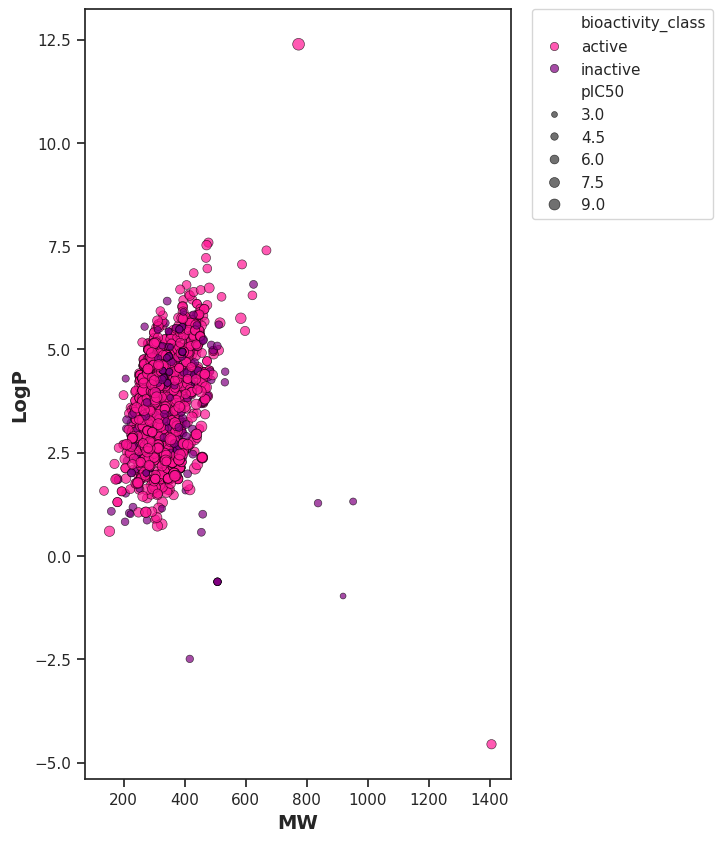

In [124]:
# scatter plot of molecular weight vs logp (solubility of molecules)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 10))

# Define a custom color palette
custom_palette = {'active': 'deeppink', 'inactive': 'purple'}  # Replace with your class names

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class',
                size='pIC50', edgecolor='black', alpha=0.7,
                palette=custom_palette) # Use the custom palette

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0) # so that the legend is outside the plot
plt.savefig('Norepinephrine_plot_MW_vs_LogP.pdf')

### Save the MW vs LogP scatterplot visualization

In [125]:
# copy the file to google drive to be accessible within colab
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [129]:
# copy the file to the visualization folder
! cp Norepinephrine_plot_MW_vs_LogP.pdf "/content/gdrive/My Drive/Colab Notebooks/visualization/"

In [130]:
# list the files in visualization folder
! ls "/content/gdrive/My Drive/Colab Notebooks/visualization/"

boxplot_ic50.pdf	   boxplot_NumHDonors.pdf			plot_ic50.pdf
boxplot_LogP.pdf	   Norepinephrine_plot_2_bioactivity_class.pdf	plot_MW_vs_LogP.pdf
boxplot_MW.pdf		   Norepinephrine_plot_MW_vs_LogP.pdf
boxplot_NumHAcceptors.pdf  plot_2_bioactivity_class.pdf


### pIC50 Visualization and Statistical Analysis

<ipython-input-132-ef159285cf5b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bioactivity_class', y='pIC50', data=df_2class,


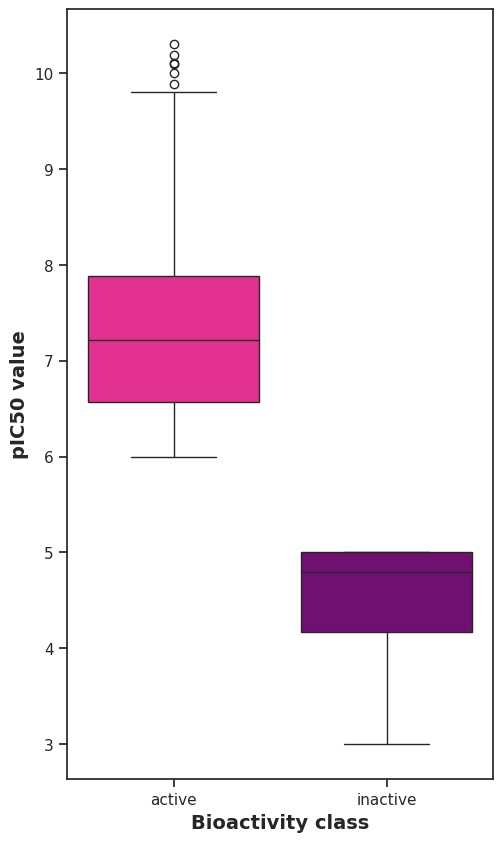

In [132]:
# pIC50 value
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 10))

# Define a custom color palette
custom_palette = {'active': 'deeppink', 'inactive': 'purple'}

sns.boxplot(x='bioactivity_class', y='pIC50', data=df_2class,
            palette=custom_palette)  # Apply the custom palette

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('Norepinephrine_boxplot_ic50.pdf')

**Explanation:** <br>The boxplot suggests that the **"active" compounds** tend to have higher pIC50 values and a more consistent distribution of inhibitory potency compared to the "inactive" compounds. However, there are a few outliers in the "inactive" group that may warrant further investigation. <br> <br> The **"inactive" class** has a very narrow box plot because of its small IQR and short whiskers, suggesting that the pIC50 values for this group are relatively similar.

#### Saving the visualization

In [133]:
# copy the file to the visualization folder
! cp Norepinephrine_boxplot_ic50.pdf "/content/gdrive/My Drive/Colab Notebooks/visualization/"

In [134]:
# list the files in visualization folder
! ls "/content/gdrive/My Drive/Colab Notebooks/visualization/"

boxplot_ic50.pdf		 Norepinephrine_plot_2_bioactivity_class.pdf
boxplot_LogP.pdf		 Norepinephrine_plot_MW_vs_LogP.pdf
boxplot_MW.pdf			 plot_2_bioactivity_class.pdf
boxplot_NumHAcceptors.pdf	 plot_ic50.pdf
boxplot_NumHDonors.pdf		 plot_MW_vs_LogP.pdf
Norepinephrine_boxplot_ic50.pdf


#### Statistical Analysis | Mann-Whitney U Test

To look at the difference between the two bioactivity class. The **statistical significance** of the difference whether they are different or not will be tested.

In [135]:
! pip install -q scipy

     |████████████████████████████████| 38.1 MB 1.3 MB/s 


In [136]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [137]:
# compare active class and inactive class to see if there is a statistical significance for the pIC50 variable
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,418404.0,9.841310e-139,0.05,Different distribution (reject H0)


**Legend:** <br>

*  ** Descriptor: **The name of the variable being compared (in this case, "PIC50"). <br><br>
*   **Statistics:** The test statistic calculated by the Mann-Whitney U test. This value represents the degree of overlap between the two groups.<br><br>
*  ** p:** The p-value associated with the test statistic. It indicates the probability of observing a test statistic as extreme or more extreme than the calculated one, assuming that there is no difference between the two groups.<br><br>
*   **alpha:** The significance level (in this case, 0.05). It is the threshold used to determine whether to reject the null hypothesis.<br><br>
*   **Interpretation:** The conclusion based on the p-value and alpha level. In this case, the interpretation is "Different distribution (reject H0)", meaning that the distributions of the "PIC50" values for the "active" and "inactive" groups are significantly different.


**Explanation:** <br>
The p value is low and we reject the null hypothesis. This suggests that there is a meaningful difference in the inhibitory potency (as measured by PIC50) between these two groups.

### Molecular Weight Visualization and Statistical Analysis

<ipython-input-138-219f08d1e2a4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bioactivity_class', y='MW', data=df_2class,


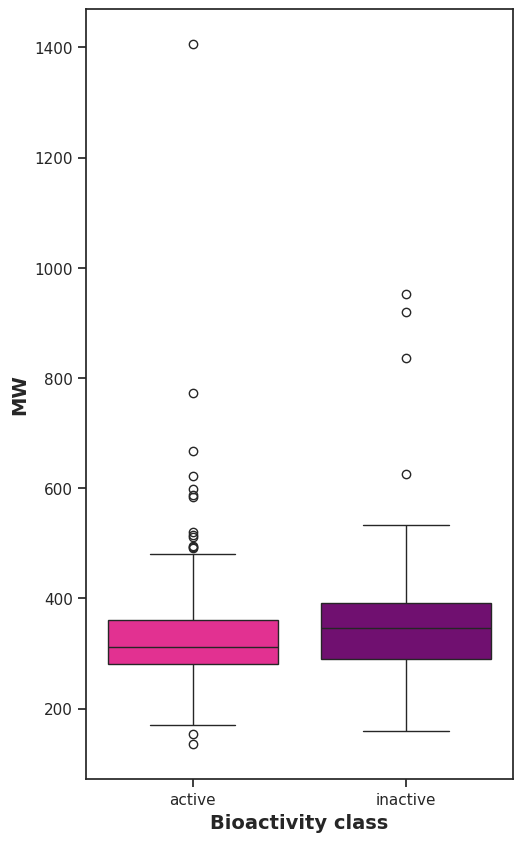

In [138]:
# molecular weight box plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 10))

# Define a custom color palette
custom_palette = {'active': 'deeppink', 'inactive': 'purple'}

sns.boxplot(x='bioactivity_class', y='MW', data=df_2class,
            palette=custom_palette)  # Apply the custom palette

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('Norepinephrine_boxplot_MW.pdf')

In [139]:
# copy the file to the visualization folder
! cp Norepinephrine_boxplot_MW.pdf "/content/gdrive/My Drive/Colab Notebooks/visualization/"

In [140]:
# list the files in visualization folder
! ls "/content/gdrive/My Drive/Colab Notebooks/visualization/"

boxplot_ic50.pdf		 Norepinephrine_boxplot_MW.pdf
boxplot_LogP.pdf		 Norepinephrine_plot_2_bioactivity_class.pdf
boxplot_MW.pdf			 Norepinephrine_plot_MW_vs_LogP.pdf
boxplot_NumHAcceptors.pdf	 plot_2_bioactivity_class.pdf
boxplot_NumHDonors.pdf		 plot_ic50.pdf
Norepinephrine_boxplot_ic50.pdf  plot_MW_vs_LogP.pdf


#### Statisctical Analysis

In [141]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,170227.0,0.000003,0.05,Different distribution (reject H0)


### LogP Molecular Weight and Statistical Anaysis

<ipython-input-142-49ddca478f80>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bioactivity_class', y='LogP', data=df_2class,


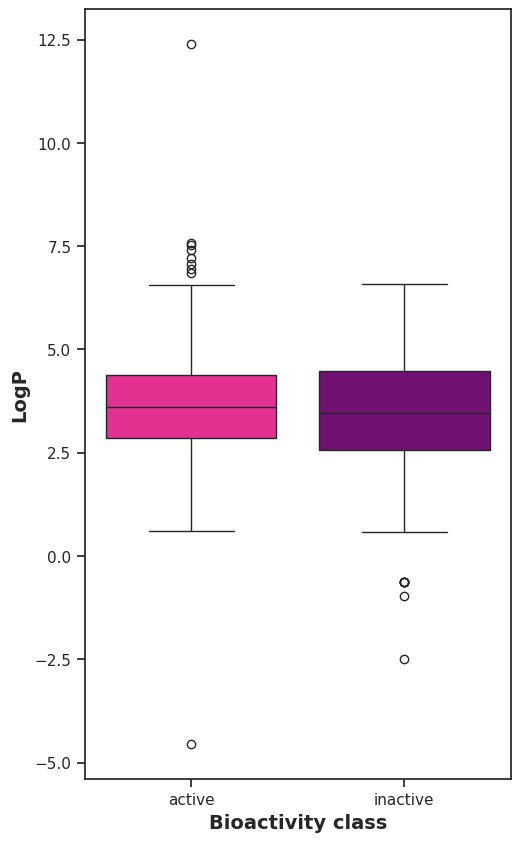

In [142]:
# LogP box plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 10))

# Define a custom color palette
custom_palette = {'active': 'deeppink', 'inactive': 'purple'}

sns.boxplot(x='bioactivity_class', y='LogP', data=df_2class,
            palette=custom_palette)  # Apply the custom palette

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('Norepinephrine_boxplot_LogP.pdf')

In [143]:
# copy the file to the visualization folder
! cp Norepinephrine_boxplot_LogP.pdf "/content/gdrive/My Drive/Colab Notebooks/visualization/"

In [144]:
# list the files in visualization folder
! ls "/content/gdrive/My Drive/Colab Notebooks/visualization/"

boxplot_ic50.pdf		 Norepinephrine_boxplot_MW.pdf
boxplot_LogP.pdf		 Norepinephrine_plot_2_bioactivity_class.pdf
boxplot_MW.pdf			 Norepinephrine_plot_MW_vs_LogP.pdf
boxplot_NumHAcceptors.pdf	 plot_2_bioactivity_class.pdf
boxplot_NumHDonors.pdf		 plot_ic50.pdf
Norepinephrine_boxplot_ic50.pdf  plot_MW_vs_LogP.pdf
Norepinephrine_boxplot_LogP.pdf


#### Statistical Analysis

In [145]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,216508.0,0.381304,0.05,Same distribution (fail to reject H0)


### NumHDonors Visualization and Statistical Analysis

<ipython-input-146-4674e82a4c4b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_2class,


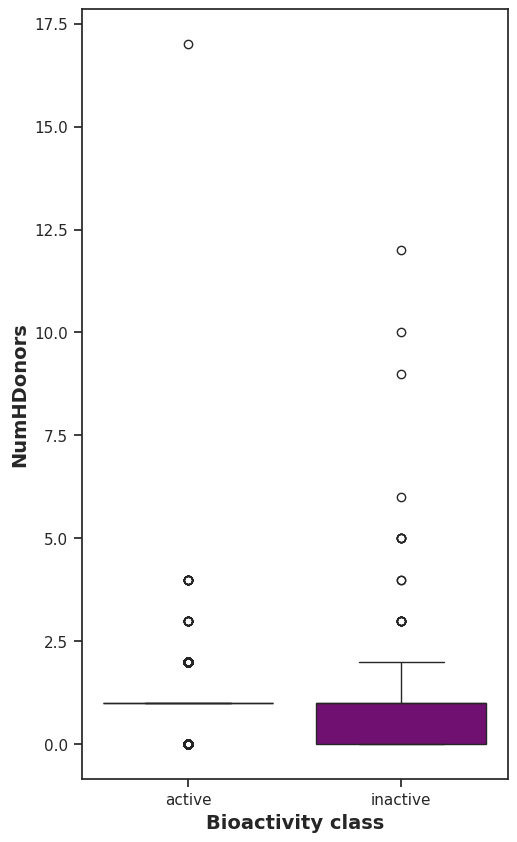

In [146]:
# NumHDonors box plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 10))

# Define a custom color palette
custom_palette = {'active': 'deeppink', 'inactive': 'purple'}

sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_2class,
            palette=custom_palette)  # Apply the custom palette

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('Norepinephrine_boxplot_NumHDonors.pdf')

In [147]:
# copy the file to the visualization folder
! cp Norepinephrine_boxplot_NumHDonors.pdf "/content/gdrive/My Drive/Colab Notebooks/visualization/"

In [148]:
# list the files in visualization folder
! ls "/content/gdrive/My Drive/Colab Notebooks/visualization/"

boxplot_ic50.pdf		 Norepinephrine_boxplot_MW.pdf
boxplot_LogP.pdf		 Norepinephrine_boxplot_NumHDonors.pdf
boxplot_MW.pdf			 Norepinephrine_plot_2_bioactivity_class.pdf
boxplot_NumHAcceptors.pdf	 Norepinephrine_plot_MW_vs_LogP.pdf
boxplot_NumHDonors.pdf		 plot_2_bioactivity_class.pdf
Norepinephrine_boxplot_ic50.pdf  plot_ic50.pdf
Norepinephrine_boxplot_LogP.pdf  plot_MW_vs_LogP.pdf


#### Statistical Analysis

In [150]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,244595.0,0.000002,0.05,Different distribution (reject H0)


### NumHAcceptors Visualization and Statistical Analysis

<ipython-input-151-216ef5dc1134>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_2class,


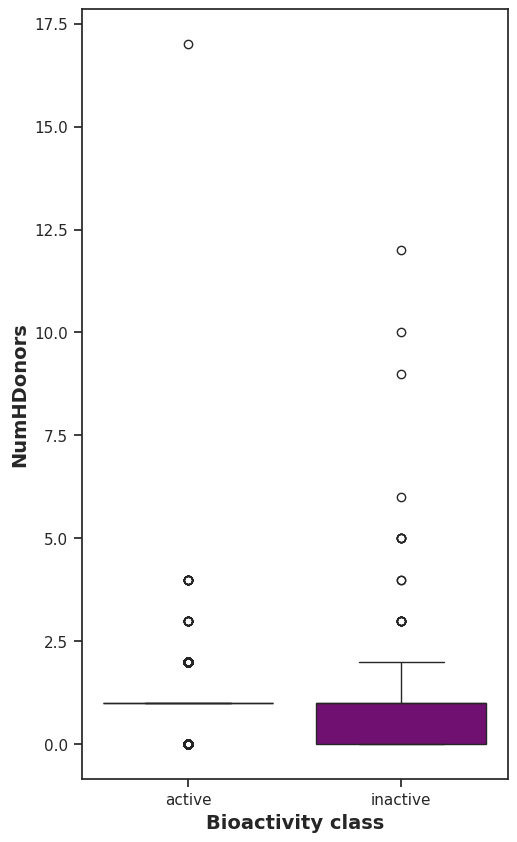

In [151]:
# NumHDonors box plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 10))

# Define a custom color palette
custom_palette = {'active': 'deeppink', 'inactive': 'purple'}

sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_2class,
            palette=custom_palette)  # Apply the custom palette

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('Norepinephrine_boxplot_NumHAcceptors.pdf')

In [152]:
# copy the file to the visualization folder
! cp Norepinephrine_boxplot_NumHAcceptors.pdf "/content/gdrive/My Drive/Colab Notebooks/visualization/"

In [153]:
# list the files in visualization folder
! ls "/content/gdrive/My Drive/Colab Notebooks/visualization/"

boxplot_ic50.pdf		 Norepinephrine_boxplot_NumHAcceptors.pdf
boxplot_LogP.pdf		 Norepinephrine_boxplot_NumHDonors.pdf
boxplot_MW.pdf			 Norepinephrine_plot_2_bioactivity_class.pdf
boxplot_NumHAcceptors.pdf	 Norepinephrine_plot_MW_vs_LogP.pdf
boxplot_NumHDonors.pdf		 plot_2_bioactivity_class.pdf
Norepinephrine_boxplot_ic50.pdf  plot_ic50.pdf
Norepinephrine_boxplot_LogP.pdf  plot_MW_vs_LogP.pdf
Norepinephrine_boxplot_MW.pdf


#### Statistical Analysis

In [154]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,153508.0,4.037312e-12,0.05,Different distribution (reject H0)


## Interpretation of Statistical Results

### Box plots

#### pIC50 values
The actives and inactives displayed ***statistically significant difference***. <br>
#### Lipinski descriptors
Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited ***no difference*** between the actives and the inactives while the other 3 descriptors (MW, NumHDonors, and NumHAcceptors) displayed ***statistically significant difference***.

The fact that the other three Lipinski descriptors (molecular weight, number of hydrogen bond donors, and number of hydrogen bond acceptors) showed no significant difference between the "active" and "inactive" groups means that *these properties are not likely to be major determinants of activity in this particular case.*

## Zipping the files

In [155]:
! zip -r -q results.zip . -i *.csv *.pdf